In [1]:
from __future__ import division
from copy import deepcopy
from MCTS import mcts
import numpy as np
import tsp as exact_solver
import matplotlib.pyplot as plt
import numpy as np
from sys import maxsize
import networkx as nx
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import queue

In [2]:
class Network():

    ### Network ###
    #
    # Create random fully connected newtowk using networkx with pisition information
    #
    # Input
    # num_of_node: number of nodes in the network
    # side_length: length of the 2-d square to place nodes on

    def __init__(self, num_of_node, side_length,seed):
        self.num_of_node = num_of_node
        self.side_length = side_length
        self.initialize_graph(seed)
        self.pos=None

    def get_pos(self):
        return self.pos

    def initialize_graph(self,seed):

        # generate random node position

        np.random.seed(seed)
        nodes = np.random.randint(self.side_length, size=self.num_of_node * 2)
        nodes = nodes.reshape(self.num_of_node, 2)
        self.positions = {key: tuple(node) for key, node in enumerate(nodes)}
        self.pos=nodes

        # setup the graph
        self.graph = nx.Graph()
        self.graph.add_nodes_from([i for i in range(self.num_of_node)])

        # setup edge and edge weight
        weighted_edges_all = []
        for i in range(self.num_of_node - 1):
            d = abs(nodes[i] - nodes[i + 1:, :])
            weight = (d[:, 0] ** 2 + d[:, 1]**2) ** 0.5
            weighted_edges = [(i, i + j, weight[j - 1]) for j in range(1, self.num_of_node - i)]
            weighted_edges_temp = np.array([[i, i + j, weight[j - 1]] for j in range(1, self.num_of_node - i)]).reshape(
                -1, 3)
            self.graph.add_weighted_edges_from(weighted_edges)
            weighted_edges_all.append(weighted_edges_temp)
        #         print(nodes)
        #         print(weight)
        #         print(weighted_edges_all)
        #         print(weighted_edges_all)
        weight_matrix = np.array(np.zeros(self.num_of_node * self.num_of_node)).reshape(self.num_of_node,
                                                                                        self.num_of_node)

        #         print(len(weighted_edges_all))
        for chunk in weighted_edges_all:
            #             print(chunk)

            indx = tuple([chunk[:, 0].astype(int), chunk[:, 1].astype(int)])
            weight_matrix[indx] = chunk[:, 2]
        weight_matrix = weight_matrix + weight_matrix.T
        #         print(weight_matrix)
        return (weight_matrix)

In [3]:
class TSPgame():
    def __init__(self, num_nodes,graph,network):
        self.num_nodes = num_nodes
        self.board = np.zeros((num_nodes, num_nodes))
        self.prev_node = 0
        self.currentPlayer = 1
        self.first_node=0
        self.network=network
        self.graph=graph

        self.edge_dict = {}
        for i in range(0,num_nodes):
            for j in range(0,num_nodes):
                if i==j:
                    self.edge_dict[(i, j)] = -float('inf')
                else:
                    self.edge_dict[(i,j)]=-graph[i][j]


    def getPossibleActions(self):

        possibleActions = []
        count=0
        for i in range(0, self.num_nodes):
            if 1 in self.board[:, i]:
                count=count+1

        for i in range(0, self.num_nodes):
            if count<self.num_nodes-1:
                if i==self.first_node:
                    continue
            if 1 not in self.board[:, i] and i != self.prev_node :
                possibleActions.append(Action(player=self.currentPlayer, x=self.prev_node, y=i))
        return possibleActions

    def takeAction(self, action):
        newState = deepcopy(self)
        newState.board[action.x][action.y] = action.player
        newState.prev_node = action.y
        newState.currentPlayer = self.currentPlayer
        return newState

    def isTerminal(self):
        for i in range(0, self.num_nodes):
            if 1 not in self.board[:, i]:
                return False
        return True

    def getReward(self):
        score = 0
        for i in range(0, self.num_nodes):
            v = i
            u = self.board[:, i].argmax()
            score = score - self.graph[u][v]
        return score

class Action():
    def __init__(self, player, x, y):
        self.player = player
        self.x = x
        self.y = y

    def get_tuple(self):
        return (self.x,self.y)

    def __str__(self):
        return str((self.x, self.y))

    def __repr__(self):
        return str(self)

    def __eq__(self, other):
        return self.__class__ == other.__class__ and self.x == other.x and self.y == other.y and self.player == other.player

    def __hash__(self):
        return hash((self.x, self.y, self.player))

# Part1

In [ ]:
n_size=10
side_length=10
seeds=list(range(1,21))
solved_total = []
for s in range(100,1001,100):
    solved = 0
    for seed in seeds:
        network = Network(n_size, side_length,seed)
        graph = network.initialize_graph(seed)
        TSP_soln = exact_solver.tsp(network.pos)[0]

        initialState = TSPgame(10, graph,network)
        edge_dict = initialState.edge_dict

        mcts_instance = mcts(iterationLimit=s)
        actions=[]
        tour = [0]
        for i in range (0,10):
            if i==0:
                cur_state=initialState
                best_child=None
            else:
                cur_state=next_state
            best_child,action = mcts_instance.search(initialState=cur_state,taken_tour=tour,parent=best_child)
            next_state = cur_state.takeAction(action)
            actions.append(action)
            tour.append(action.y)


        cost = 0
        for a in actions:
            cost = cost + edge_dict[(a.x, a.y)]
        cost = -cost

        if cost <= TSP_soln * 1.1:
            solved = solved + 1
    solved_total.append(solved)

    #print('Num of sample:', s, ' solved rate: ', solved / len(seeds))

Text(0, 0.5, 'Percentage of instances solved')

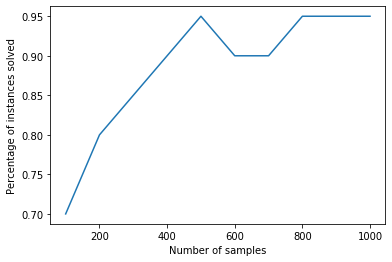

In [20]:
fig=plt.plot(list(range(100,1001,100)),np.array(solved_total)/20)
plt.xlabel('Number of samples')
plt.ylabel('Percentage of instances solved')

# Part 2

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, d=2):
        super(PolicyNetwork, self).__init__()
        self.conv1 = GCNConv(d, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 16)
        self.conv4 = GCNConv(16, 1)
        self.fc = nn.Linear(16, 1)

    def forward(self, graph):
        x, edges, choices = graph.pos, graph.edge_index, graph.y

        x = self.conv1(x, edges)
        x = F.relu(x)
        x = self.conv2(x, edges)
        x = F.relu(x)
        x = self.conv3(x, edges)
        x = F.relu(x)

        c = self.conv4(x, edges)
        choice = torch.masked_select(c.squeeze(), choices)
        choice = F.softmax(choice, dim=0)

        v = global_mean_pool(x, torch.zeros(graph.num_nodes, dtype=torch.long))
        value = self.fc(v)

        return choice, value

In [5]:
class MCTSExampleGenerator():

    def __init__(self, initialstate, example_queue, iterations=1000):
        self.mcst_instance=mcts(iterationLimit=iterations)
        self.initialstate=initialstate
        self.example_queue = example_queue
        self.iterations = iterations

    def solve(self):
        mcts_instance = self.mcst_instance
        tour=[0]
        for i in range(0, 10):
            if i == 0:
                cur_state = self.initialstate
                parent=None
            else:
                cur_state = next_state
                parent=node
            node,action = mcts_instance.search(cur_state,tour,parent)
            next_state = cur_state.takeAction(action)
            tour.append(action.y)
            self.generate_example(node.parent)

    def generate_example(self, node):

        # construct graph
        graph = node.construct_graph()

        # construct labels

        choice_probs = [(val.tour[-1], val.numVisits) for key, val in node.children.items()]
        choice_probs = sorted(choice_probs, key=lambda c: c[0])
        choice_probs = [c[1] for c in choice_probs]
        choice_probs = torch.tensor(choice_probs).to(dtype=torch.float)
        choice_probs = choice_probs / choice_probs.sum()

        choice = torch.argmax(choice_probs)

        pred_value = torch.tensor(node.totalReward/node.numVisits)

        # add to training queue
        example = {
            "graph": graph,
            "choice_probs": choice_probs,
            "choice": choice,
            "pred_value": pred_value,
        }
        self.example_queue.put(example)

In [6]:
class PolicyNetworkTrainer:

    def __init__(self, model, example_queue):
        self.model = model
        self.example_queue = example_queue
        self.losses = []

    def train_all(self):
        self.model.train()
        while not self.example_queue.empty():
            example = self.example_queue.get()
            graph, choice_probs, value = example["graph"], example["choice_probs"], example["pred_value"]

            pred_choices, pred_value = self.model(graph)
            try:
                loss = loss_fn(pred_choices, choice_probs) + (0* loss_fn(pred_value, value))
            except:
                print('shape of predicted tensor and label ')

            self.losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [ ]:
policy_network = PolicyNetwork()

optimizer = torch.optim.Adam(params=policy_network.parameters(), lr=3e-4)
loss_fn = nn.MSELoss()
train_queue = queue.Queue()

seeds=list(range(0,150))
for seed in seeds:
    network = Network(10, 6, seed)
    graph = network.initialize_graph(seed)
    # print('OPtimal solution is ', TSP_soln)
    initialState = TSPgame(10, graph, network)
    MCTSExampleGenerator(initialState, train_queue,iterations=1000).solve()

trainer = PolicyNetworkTrainer(policy_network, train_queue)

trainer.train_all()
policy_network = trainer.model
#torch.save(policy_network.state_dict(), "policy_network_no_val.pth")

# Part 3

In [ ]:
policy_network = PolicyNetwork()
policy_network.load_state_dict(torch.load("C:/Users/anvyl/Desktop/MCTS-master/policy_network_no_val.pth"))
n_size=20
side_length=6 
seeds=list(range(200,220))
solved_total = []

for s in range(100,1001,100):

    solved = 0
    for seed in seeds:
        network = Network(n_size, side_length, seed)
        graph = network.initialize_graph(seed)
        TSP_soln = exact_solver.tsp(network.pos)[0]

        initialState = TSPgame(20, graph, network)
        edge_dict = initialState.edge_dict

        mcts_instance = mcts(iterationLimit=s)
        actions = []
        tour=[0]
        for i in range(0, n_size):
            if i == 0:
                cur_state = initialState
                best_child=None
            else:
                cur_state = next_state
                best_child=child
            child, action = mcts_instance.search_policy(initialState=cur_state,model=policy_network,taken_tour=tour,parent=best_child)
            next_state = cur_state.takeAction(action)
            actions.append(action)
            tour.append(action.y)

        cost = 0
        for a in actions:
            cost = cost + edge_dict[(a.x, a.y)]
        cost = -cost

        if cost <= TSP_soln * 1.1:
            solved = solved + 1

    solved_total.append(solved)

    #print('Num of sample:', s, ' solved rate: ', solved / len(seeds))

Text(0, 0.5, 'Percentage of instances solved')

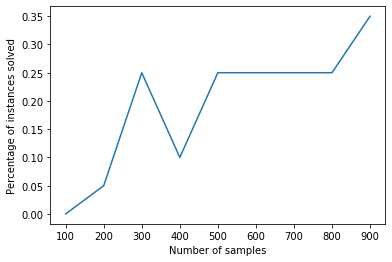

In [9]:
fig=plt.plot(list(range(100,1000,100)),np.array(solved_total)/20)
plt.xlabel('Number of samples')
plt.ylabel('Percentage of instances solved')